Problem 1


===== Training on CIFAR10 =====
Device: cuda
Prefetched dataset to GPU!
Number of parameters: 795,850
Epoch [1/50] Train Loss: 1.4699, Train Acc: 46.47% | Val Loss: 5.5975, Val Acc: 9.88% | 🔹 Train Time: 43.68s | Val Time: 31.05s | Full Epoch Time: 74.74s
Epoch [2/50] Train Loss: 1.6989, Train Acc: 38.57% | Val Loss: 1.6150, Val Acc: 40.72% | 🔹 Train Time: 5.72s | Val Time: 2.29s | Full Epoch Time: 8.01s
Epoch [3/50] Train Loss: 1.3678, Train Acc: 50.17% | Val Loss: 1.4122, Val Acc: 49.21% | 🔹 Train Time: 5.95s | Val Time: 1.84s | Full Epoch Time: 7.79s
Epoch [4/50] Train Loss: 1.2342, Train Acc: 55.49% | Val Loss: 1.2796, Val Acc: 54.44% | 🔹 Train Time: 6.54s | Val Time: 2.01s | Full Epoch Time: 8.55s
Epoch [5/50] Train Loss: 1.1343, Train Acc: 59.37% | Val Loss: 1.2533, Val Acc: 55.38% | 🔹 Train Time: 5.53s | Val Time: 1.72s | Full Epoch Time: 7.25s
Epoch [6/50] Train Loss: 1.0350, Train Acc: 63.01% | Val Loss: 1.1085, Val Acc: 61.13% | 🔹 Train Time: 5.75s | Val Time: 2.16s | Full E

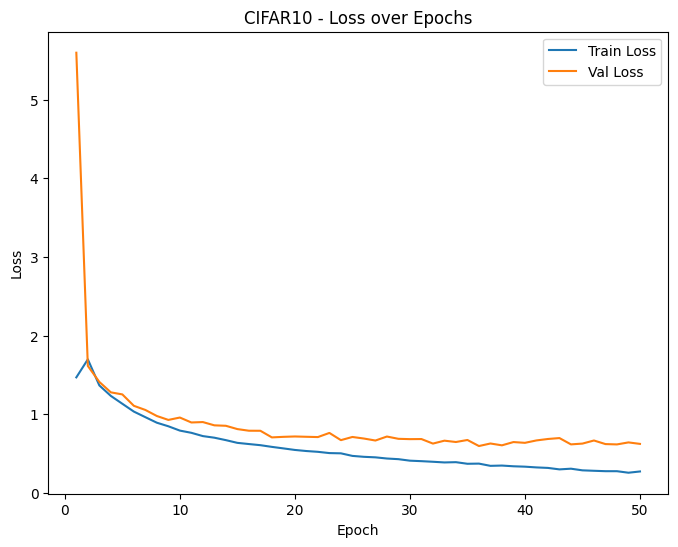


===== Training on CIFAR100 =====
Device: cuda
Prefetched dataset to GPU!
Number of parameters: 818,980
Epoch [1/50] Train Loss: 1.7417, Train Acc: 45.37% | Val Loss: 1.4005, Val Acc: 50.72% | 🔹 Train Time: 45.03s | Val Time: 34.20s | Full Epoch Time: 79.24s
Epoch [2/50] Train Loss: 1.1293, Train Acc: 59.98% | Val Loss: 1.1302, Val Acc: 60.48% | 🔹 Train Time: 5.85s | Val Time: 1.31s | Full Epoch Time: 7.16s
Epoch [3/50] Train Loss: 0.9524, Train Acc: 66.14% | Val Loss: 1.2191, Val Acc: 57.81% | 🔹 Train Time: 5.39s | Val Time: 1.26s | Full Epoch Time: 6.65s
Epoch [4/50] Train Loss: 0.8720, Train Acc: 69.26% | Val Loss: 1.0211, Val Acc: 64.71% | 🔹 Train Time: 4.52s | Val Time: 1.35s | Full Epoch Time: 5.87s
Epoch [5/50] Train Loss: 0.7968, Train Acc: 72.00% | Val Loss: 0.8026, Val Acc: 71.71% | 🔹 Train Time: 5.80s | Val Time: 1.36s | Full Epoch Time: 7.16s
Epoch [6/50] Train Loss: 0.7397, Train Acc: 74.02% | Val Loss: 1.0085, Val Acc: 66.61% | 🔹 Train Time: 4.58s | Val Time: 1.31s | Full

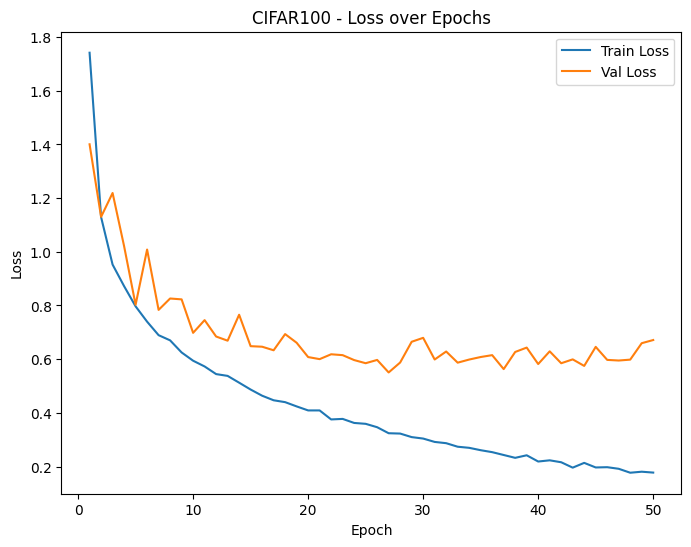

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# -------------------------------
# 1. Updated Simplified AlexNet (Without Dropout)
# -------------------------------
class SimplifiedAlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimplifiedAlexNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16
            
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8

            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            
            nn.Conv2d(128, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 4x4
        )
        
        # After final pool, feature map is 4x4 with 64 channels => 64*4*4=1024
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),

            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),

            nn.Linear(256, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# -------------------------------
# 2. Training and Validation
# -------------------------------
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return running_loss / total, correct / total

# -------------------------------
# 3. Main Training Function
# -------------------------------
def train_and_evaluate(
    dataset_name='CIFAR10',
    num_classes=10,
    epochs=50,
    batch_size=512,
    learning_rate=1e-3
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n===== Training on {dataset_name} =====")
    print(f"Device: {device}")
    
    # 1. Load Dataset with Augmentation & Normalization
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    
    full_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    # 2. 80-20 Train-Val Split
    total_size = len(full_dataset)
    val_size = int(0.2 * total_size)
    train_size = total_size - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    # Prefetch dataset to GPU
    train_dataset.data = torch.tensor(train_dataset.dataset.data[train_dataset.indices], dtype=torch.float16, device="cuda")
    train_dataset.targets = torch.tensor(train_dataset.dataset.targets)[train_dataset.indices].to(device)

    val_dataset.data = torch.tensor(val_dataset.dataset.data[val_dataset.indices], dtype=torch.float16, device="cuda")
    val_dataset.targets = torch.tensor(val_dataset.dataset.targets)[val_dataset.indices].to(device)

    print("Prefetched dataset to GPU!")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)
    
    # 3. Initialize Model, Loss, Optimizer
    model = SimplifiedAlexNet(num_classes=num_classes).to(device)
    print(f"Number of parameters: {count_parameters(model):,}")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.99)

    # 4. Training Loop
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(1, epochs + 1):
        start_time = time.time()
        
        train_start_time = time.time()
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_time = time.time() - train_start_time

        val_start_time = time.time()
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
        val_time = time.time() - val_start_time
        
        train_losses.append(tr_loss)
        train_accs.append(tr_acc)
        val_losses.append(val_loss if val_loss is not None else val_losses[-1])
        val_accs.append(val_acc if val_acc is not None else val_accs[-1])

        scheduler.step()
        
        elapsed = time.time() - start_time
        print(f"Epoch [{epoch}/{epochs}] "
              f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}% | "
              f"🔹 Train Time: {train_time:.2f}s | Val Time: {val_time:.2f}s | Full Epoch Time: {elapsed:.2f}s")

    # 5. Plot Loss Curves
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
    plt.title(f'{dataset_name} - Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return model

if __name__ == "__main__":
    model_cifar10 = train_and_evaluate(dataset_name='CIFAR10', num_classes=10)
    model_cifar100 = train_and_evaluate(dataset_name='CIFAR100', num_classes=100)


===== Training on CIFAR10 =====
Device: cuda
Prefetched dataset to GPU!
Number of parameters: 795,850
Epoch [1/50] Train Loss: 1.5477, Train Acc: 43.04% | Val Loss: 1.3995, Val Acc: 49.51% | 🔹 Train Time: 45.82s | Val Time: 30.26s | Full Epoch Time: 76.08s
Epoch [2/50] Train Loss: 1.1871, Train Acc: 56.78% | Val Loss: 1.2201, Val Acc: 57.15% | 🔹 Train Time: 5.73s | Val Time: 1.56s | Full Epoch Time: 7.29s
Epoch [3/50] Train Loss: 1.0281, Train Acc: 63.34% | Val Loss: 1.0226, Val Acc: 63.84% | 🔹 Train Time: 4.77s | Val Time: 1.51s | Full Epoch Time: 6.28s
Epoch [4/50] Train Loss: 0.9450, Train Acc: 66.32% | Val Loss: 0.9201, Val Acc: 67.34% | 🔹 Train Time: 5.24s | Val Time: 1.71s | Full Epoch Time: 6.95s
Epoch [5/50] Train Loss: 0.8898, Train Acc: 68.37% | Val Loss: 1.0693, Val Acc: 63.00% | 🔹 Train Time: 4.31s | Val Time: 1.17s | Full Epoch Time: 5.48s
Epoch [6/50] Train Loss: 0.8352, Train Acc: 70.47% | Val Loss: 0.9649, Val Acc: 65.36% | 🔹 Train Time: 4.40s | Val Time: 1.19s | Full 

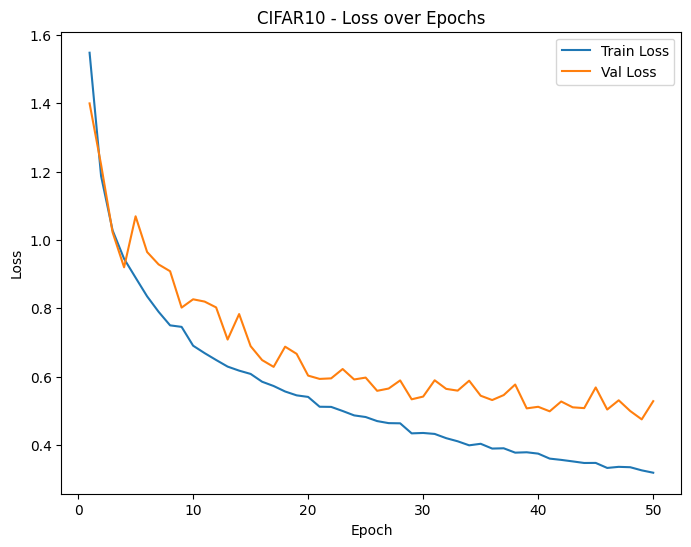


===== Training on CIFAR100 =====
Device: cuda
Prefetched dataset to GPU!
Number of parameters: 818,980
Epoch [1/50] Train Loss: 3.9444, Train Acc: 10.06% | Val Loss: 3.7101, Val Acc: 13.53% | 🔹 Train Time: 47.81s | Val Time: 35.77s | Full Epoch Time: 83.58s
Epoch [2/50] Train Loss: 3.3395, Train Acc: 18.87% | Val Loss: 3.4153, Val Acc: 18.26% | 🔹 Train Time: 4.83s | Val Time: 1.67s | Full Epoch Time: 6.50s
Epoch [3/50] Train Loss: 3.0003, Train Acc: 24.69% | Val Loss: 3.0832, Val Acc: 23.88% | 🔹 Train Time: 5.53s | Val Time: 2.38s | Full Epoch Time: 7.90s
Epoch [4/50] Train Loss: 2.7760, Train Acc: 29.04% | Val Loss: 2.7308, Val Acc: 29.53% | 🔹 Train Time: 7.52s | Val Time: 1.89s | Full Epoch Time: 9.41s
Epoch [5/50] Train Loss: 2.6090, Train Acc: 32.63% | Val Loss: 2.7794, Val Acc: 29.45% | 🔹 Train Time: 5.70s | Val Time: 1.72s | Full Epoch Time: 7.42s
Epoch [6/50] Train Loss: 2.4923, Train Acc: 35.09% | Val Loss: 2.4666, Val Acc: 35.55% | 🔹 Train Time: 6.32s | Val Time: 1.76s | Full

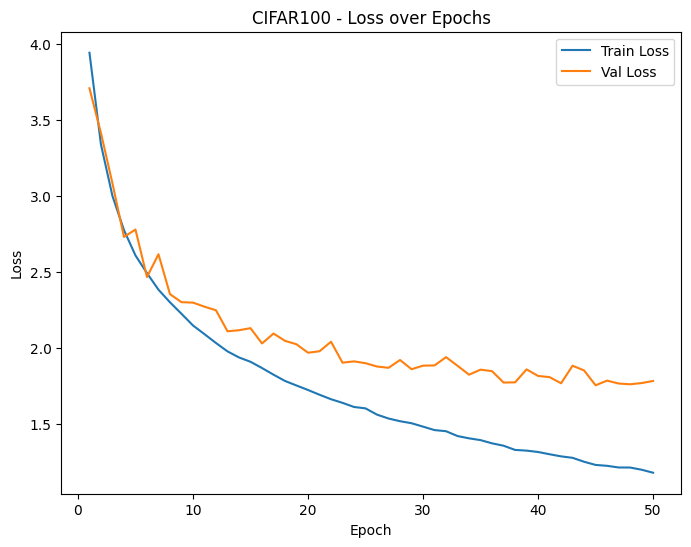

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time


torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# -------------------------------
# 1. Updated Simplified AlexNet
# -------------------------------
class SimplifiedAlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimplifiedAlexNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x16
            
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8x8

            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Dropout(0.2),
            
            nn.Conv2d(128, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 4x4
        )
        
        # After final pool, feature map is 4x4 with 64 channels => 64*4*4=1024
        self.classifier = nn.Sequential(
            nn.Dropout(0.15),

            nn.Linear(64 * 4 * 4, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Dropout(0.2),

            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            
            nn.Linear(256, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# -------------------------------
# 2. Training and Validation
# -------------------------------
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return running_loss / total, correct / total

# -------------------------------
# 3. Main Training Function
# -------------------------------
def train_and_evaluate(
    dataset_name='CIFAR10',
    num_classes=10,
    epochs=50,
    batch_size=512,
    learning_rate=1e-3
):
    """
    Train and evaluate SimplifiedAlexNet on CIFAR-10 or CIFAR-100.
    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n===== Training on {dataset_name} =====")
    print(f"Device: {device}")
    
    # 1. Load Dataset with Augmentation & Normalization
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    
    if dataset_name == 'CIFAR10':
        full_dataset = torchvision.datasets.CIFAR10(
            root='./data',
            train=True,
            download=True,
            transform=transform
        )
    else:  # CIFAR100
        full_dataset = torchvision.datasets.CIFAR100(
            root='./data',
            train=True,
            download=True,
            transform=transform
        )
    
    # 2. 80-20 Train-Val Split
    total_size = len(full_dataset)
    val_size = int(0.2 * total_size)
    train_size = total_size - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    train_dataset.data = torch.tensor(train_dataset.dataset.data[train_dataset.indices], dtype=torch.float16, device="cuda")
    train_dataset.targets = torch.tensor(train_dataset.dataset.targets)[train_dataset.indices].to(device)

    val_dataset.data = torch.tensor(val_dataset.dataset.data[val_dataset.indices], dtype=torch.float16, device="cuda")
    val_dataset.targets = torch.tensor(val_dataset.dataset.targets)[val_dataset.indices].to(device)

    print("Prefetched dataset to GPU!")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)
    
    # 3. Initialize Model, Loss, Optimizer
    model = SimplifiedAlexNet(num_classes=num_classes).to(device)
    print(f"Number of parameters: {count_parameters(model):,}")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.99)
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

    
    # 4. Training Loop
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(1, epochs+1):
        start_time = time.time()
        
        train_start_time = time.time()
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_time = time.time() - train_start_time

        val_start_time = time.time()
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
        val_time = time.time() - val_start_time
        
        train_losses.append(tr_loss)
        train_accs.append(tr_acc)
        # val_losses.append(val_loss)
        # val_accs.append(val_acc)
        val_losses.append(val_loss if val_loss is not None else val_losses[-1])
        val_accs.append(val_acc if val_acc is not None else val_accs[-1])

        scheduler.step()
        
        elapsed = time.time() - start_time
        print(f"Epoch [{epoch}/{epochs}] "
              f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc*100:.2f}% | "
              f"Val Loss: {'Skipped' if val_loss is None else f'{val_loss:.4f}'}, "
              f"Val Acc: {'Skipped' if val_acc is None else f'{val_acc*100:.2f}%'} | "
              f"🔹 Train Time: {train_time:.2f}s | Val Time: {val_time:.2f}s | Full Epoch Time: {elapsed:.2f}s")

    
    # 5. Plot Loss Curves
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
    plt.title(f'{dataset_name} - Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return model

# -------------------------------
# 4. Train for CIFAR-10 and CIFAR-100
# -------------------------------
if __name__ == "__main__":
    model_cifar10 = train_and_evaluate(dataset_name='CIFAR10', num_classes=10)
    model_cifar100 = train_and_evaluate(dataset_name='CIFAR100', num_classes=100)


Problem 2


===== Training on CIFAR10 with VGGNet =====
Device: cuda
Number of parameters: 798,858
Epoch [1/50] Train Loss: 1.5392, Train Acc: 44.24% | Val Loss: 1.9491, Val Acc: 40.44% | Time: 65.96s
Epoch [2/50] Train Loss: 1.0910, Train Acc: 61.06% | Val Loss: 1.2231, Val Acc: 56.42% | Time: 7.26s
Epoch [3/50] Train Loss: 0.8935, Train Acc: 68.54% | Val Loss: 1.0920, Val Acc: 62.10% | Time: 7.15s
Epoch [4/50] Train Loss: 0.7738, Train Acc: 72.87% | Val Loss: 0.8654, Val Acc: 69.51% | Time: 7.12s
Epoch [5/50] Train Loss: 0.6956, Train Acc: 75.46% | Val Loss: 0.8872, Val Acc: 69.35% | Time: 7.13s
Epoch [6/50] Train Loss: 0.6480, Train Acc: 77.31% | Val Loss: 1.1764, Val Acc: 61.58% | Time: 7.15s
Epoch [7/50] Train Loss: 0.5970, Train Acc: 79.05% | Val Loss: 0.8398, Val Acc: 71.00% | Time: 7.25s
Epoch [8/50] Train Loss: 0.5634, Train Acc: 80.42% | Val Loss: 0.6821, Val Acc: 76.69% | Time: 7.42s
Epoch [9/50] Train Loss: 0.5161, Train Acc: 81.95% | Val Loss: 0.7182, Val Acc: 75.94% | Time: 7.34s
Ep

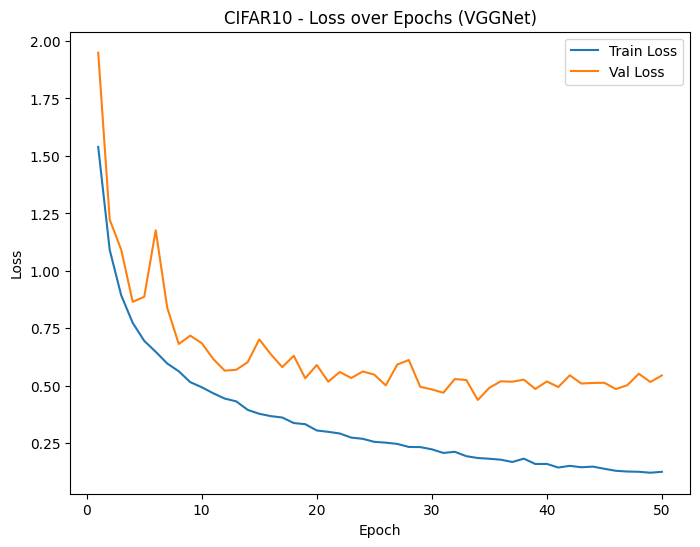


===== Training on CIFAR100 with VGGNet =====
Device: cuda
Number of parameters: 810,468
Epoch [1/50] Train Loss: 3.9708, Train Acc: 10.53% | Val Loss: 3.7911, Val Acc: 12.22% | Time: 63.95s
Epoch [2/50] Train Loss: 3.4066, Train Acc: 18.80% | Val Loss: 3.3001, Val Acc: 20.10% | Time: 7.21s
Epoch [3/50] Train Loss: 3.0025, Train Acc: 25.75% | Val Loss: 2.9911, Val Acc: 25.19% | Time: 7.13s
Epoch [4/50] Train Loss: 2.6718, Train Acc: 31.85% | Val Loss: 2.7821, Val Acc: 29.70% | Time: 7.17s
Epoch [5/50] Train Loss: 2.4127, Train Acc: 37.30% | Val Loss: 2.5597, Val Acc: 34.34% | Time: 7.20s
Epoch [6/50] Train Loss: 2.2173, Train Acc: 41.07% | Val Loss: 2.4292, Val Acc: 36.86% | Time: 7.11s
Epoch [7/50] Train Loss: 2.0582, Train Acc: 44.80% | Val Loss: 2.3894, Val Acc: 37.41% | Time: 7.20s
Epoch [8/50] Train Loss: 1.9441, Train Acc: 47.08% | Val Loss: 2.4609, Val Acc: 36.96% | Time: 7.07s
Epoch [9/50] Train Loss: 1.8382, Train Acc: 49.54% | Val Loss: 2.2932, Val Acc: 40.03% | Time: 7.12s
E

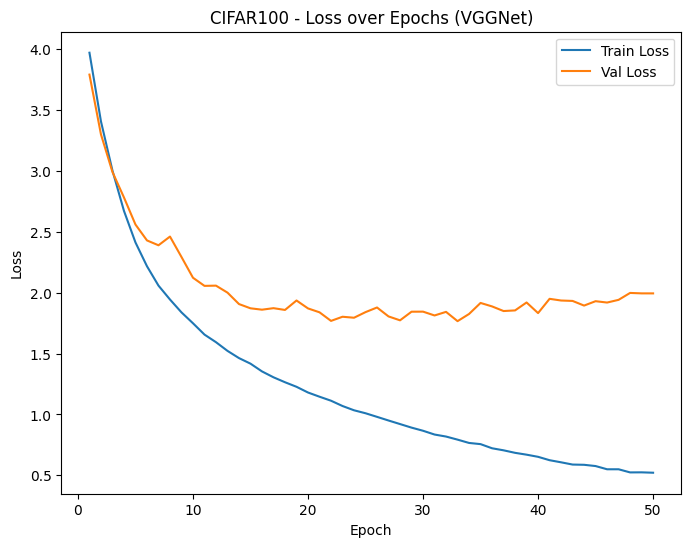

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# -------------------------------
# 1. Simplified VGGNet Model
# -------------------------------
class SimplifiedVGGNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimplifiedVGGNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16
            
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Conv2d(64, 96, kernel_size=5, padding=2),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8
            
            nn.Conv2d(96, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 4x4
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# -------------------------------
# 2. Training and Validation Functions
# -------------------------------
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


# -------------------------------
# 3. Training Function
# -------------------------------
def train_and_evaluate_vgg(
    dataset_name='CIFAR10',
    num_classes=10,
    epochs=50,
    batch_size=512,
    learning_rate=1e-3
):
    """
    Train and evaluate SimplifiedVGGNet on CIFAR-10 or CIFAR-100.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n===== Training on {dataset_name} with VGGNet =====")
    print(f"Device: {device}")

    # 1. Load Dataset with Augmentation & Normalization
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

    if dataset_name == 'CIFAR10':
        full_dataset = torchvision.datasets.CIFAR10(
            root='./data',
            train=True,
            download=True,
            transform=transform
        )
    else:  # CIFAR100
        full_dataset = torchvision.datasets.CIFAR100(
            root='./data',
            train=True,
            download=True,
            transform=transform
        )

    # 2. 80-20 Train-Val Split
    total_size = len(full_dataset)
    val_size = int(0.2 * total_size)
    train_size = total_size - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)

    # 3. Initialize Model, Loss, Optimizer
    model = SimplifiedVGGNet(num_classes=num_classes).to(device)
    print(f"Number of parameters: {count_parameters(model):,}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.99)

    # 4. Training Loop
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(1, epochs+1):
        start_time = time.time()

        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        train_accs.append(tr_acc)
        val_accs.append(val_acc)

        scheduler.step()

        elapsed = time.time() - start_time
        print(f"Epoch [{epoch}/{epochs}] "
              f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}% | "
              f"Time: {elapsed:.2f}s")

    # 5. Plot Loss Curves
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
    plt.title(f'{dataset_name} - Loss over Epochs (VGGNet)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model


# -------------------------------
# 4. Train VGGNet for CIFAR-10 and CIFAR-100
# -------------------------------
if __name__ == "__main__":
    model_vgg_cifar10 = train_and_evaluate_vgg(dataset_name='CIFAR10', num_classes=10)
    model_vgg_cifar100 = train_and_evaluate_vgg(dataset_name='CIFAR100', num_classes=100)



===== Training on CIFAR10 with VGGNet =====
Device: cuda
Number of parameters: 798,858
Epoch [1/50] Train Loss: 1.6436, Train Acc: 39.17% | Val Loss: 1.7154, Val Acc: 37.85% | Time: 77.85s
Epoch [2/50] Train Loss: 1.2363, Train Acc: 55.27% | Val Loss: 1.1465, Val Acc: 58.64% | Time: 7.59s
Epoch [3/50] Train Loss: 1.0496, Train Acc: 62.26% | Val Loss: 1.0113, Val Acc: 63.46% | Time: 7.67s
Epoch [4/50] Train Loss: 0.9166, Train Acc: 67.44% | Val Loss: 1.0393, Val Acc: 64.08% | Time: 7.94s
Epoch [5/50] Train Loss: 0.8273, Train Acc: 70.68% | Val Loss: 0.8396, Val Acc: 70.28% | Time: 7.74s
Epoch [6/50] Train Loss: 0.7656, Train Acc: 73.02% | Val Loss: 0.9545, Val Acc: 66.97% | Time: 7.67s
Epoch [7/50] Train Loss: 0.7246, Train Acc: 74.57% | Val Loss: 0.8427, Val Acc: 70.98% | Time: 7.28s
Epoch [8/50] Train Loss: 0.6720, Train Acc: 76.46% | Val Loss: 0.7188, Val Acc: 75.72% | Time: 7.63s
Epoch [9/50] Train Loss: 0.6457, Train Acc: 77.50% | Val Loss: 0.7281, Val Acc: 75.04% | Time: 7.77s
Ep

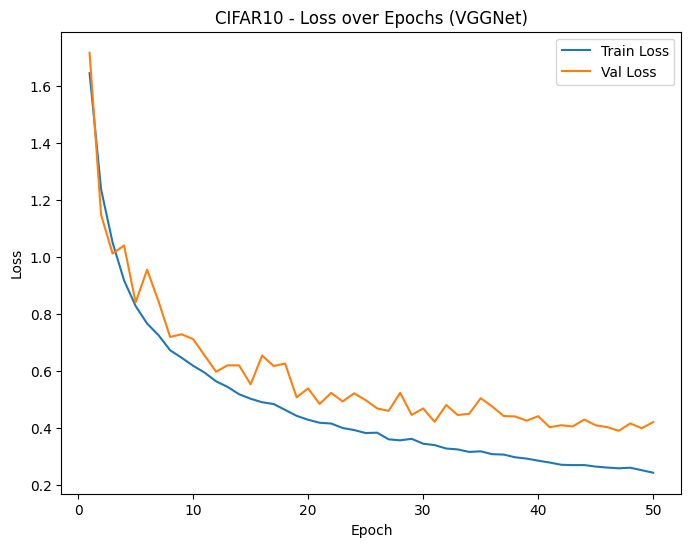


===== Training on CIFAR100 with VGGNet =====
Device: cuda
Number of parameters: 810,468
Epoch [1/50] Train Loss: 4.1510, Train Acc: 6.88% | Val Loss: 4.0001, Val Acc: 8.70% | Time: 76.50s
Epoch [2/50] Train Loss: 3.6872, Train Acc: 13.10% | Val Loss: 3.7048, Val Acc: 12.73% | Time: 7.89s
Epoch [3/50] Train Loss: 3.4101, Train Acc: 17.68% | Val Loss: 3.3231, Val Acc: 19.22% | Time: 8.16s
Epoch [4/50] Train Loss: 3.1542, Train Acc: 22.29% | Val Loss: 3.0742, Val Acc: 23.54% | Time: 8.83s
Epoch [5/50] Train Loss: 2.9331, Train Acc: 26.24% | Val Loss: 2.9188, Val Acc: 26.79% | Time: 8.20s
Epoch [6/50] Train Loss: 2.7614, Train Acc: 29.58% | Val Loss: 2.7590, Val Acc: 29.48% | Time: 9.11s
Epoch [7/50] Train Loss: 2.5933, Train Acc: 32.95% | Val Loss: 2.6314, Val Acc: 31.76% | Time: 8.31s
Epoch [8/50] Train Loss: 2.4906, Train Acc: 34.84% | Val Loss: 2.5195, Val Acc: 34.93% | Time: 8.82s
Epoch [9/50] Train Loss: 2.3656, Train Acc: 37.44% | Val Loss: 2.4790, Val Acc: 35.52% | Time: 8.46s
Epo

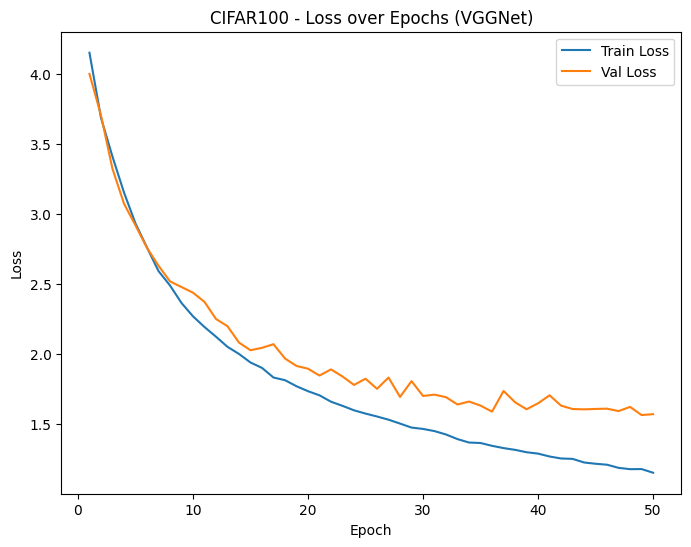

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# -------------------------------
# 1. Simplified VGGNet Model
# -------------------------------
class SimplifiedVGGNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimplifiedVGGNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.15),
            
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16
            
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.2),
            
            nn.Conv2d(64, 96, kernel_size=5, padding=2),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8
            
            nn.Conv2d(96, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.2),
            
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 4x4
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),

            nn.Linear(64 * 4 * 4, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.15),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# -------------------------------
# 2. Training and Validation Functions
# -------------------------------
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


# -------------------------------
# 3. Training Function
# -------------------------------
def train_and_evaluate_vgg(
    dataset_name='CIFAR10',
    num_classes=10,
    epochs=50,
    batch_size=512,
    learning_rate=1e-3
):
    """
    Train and evaluate SimplifiedVGGNet on CIFAR-10 or CIFAR-100.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n===== Training on {dataset_name} with VGGNet =====")
    print(f"Device: {device}")

    # 1. Load Dataset with Augmentation & Normalization
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

    if dataset_name == 'CIFAR10':
        full_dataset = torchvision.datasets.CIFAR10(
            root='./data',
            train=True,
            download=True,
            transform=transform
        )
    else:  # CIFAR100
        full_dataset = torchvision.datasets.CIFAR100(
            root='./data',
            train=True,
            download=True,
            transform=transform
        )

    # 2. 80-20 Train-Val Split
    total_size = len(full_dataset)
    val_size = int(0.2 * total_size)
    train_size = total_size - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)

    # 3. Initialize Model, Loss, Optimizer
    model = SimplifiedVGGNet(num_classes=num_classes).to(device)
    print(f"Number of parameters: {count_parameters(model):,}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.99)

    # 4. Training Loop
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(1, epochs+1):
        start_time = time.time()

        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        train_accs.append(tr_acc)
        val_accs.append(val_acc)

        scheduler.step()

        elapsed = time.time() - start_time
        print(f"Epoch [{epoch}/{epochs}] "
              f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}% | "
              f"Time: {elapsed:.2f}s")

    # 5. Plot Loss Curves
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
    plt.title(f'{dataset_name} - Loss over Epochs (VGGNet)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model


# -------------------------------
# 4. Train VGGNet for CIFAR-10 and CIFAR-100
# -------------------------------
if __name__ == "__main__":
    model_vgg_cifar10 = train_and_evaluate_vgg(dataset_name='CIFAR10', num_classes=10)
    model_vgg_cifar100 = train_and_evaluate_vgg(dataset_name='CIFAR100', num_classes=100)


Problem 3


===== Training on CIFAR10 with ResNet-18 =====
Device: cuda
Number of parameters: 1,064,474
Epoch [1/50] Train Loss: 1.6489, Val Loss: 1.4862, Val Acc: 45.54% | Time: 72.64s
Epoch [2/50] Train Loss: 1.2837, Val Loss: 1.5048, Val Acc: 49.75% | Time: 9.12s
Epoch [3/50] Train Loss: 1.0777, Val Loss: 1.1488, Val Acc: 59.66% | Time: 9.00s
Epoch [4/50] Train Loss: 0.9602, Val Loss: 0.9605, Val Acc: 65.42% | Time: 9.01s
Epoch [5/50] Train Loss: 0.8767, Val Loss: 1.1580, Val Acc: 62.18% | Time: 8.99s
Epoch [6/50] Train Loss: 0.7855, Val Loss: 0.8704, Val Acc: 70.03% | Time: 9.03s
Epoch [7/50] Train Loss: 0.7183, Val Loss: 0.7806, Val Acc: 72.97% | Time: 8.98s
Epoch [8/50] Train Loss: 0.6758, Val Loss: 0.7323, Val Acc: 74.77% | Time: 9.41s
Epoch [9/50] Train Loss: 0.6280, Val Loss: 0.7940, Val Acc: 72.14% | Time: 9.34s
Epoch [10/50] Train Loss: 0.5970, Val Loss: 0.6388, Val Acc: 78.03% | Time: 9.13s
Epoch [11/50] Train Loss: 0.5613, Val Loss: 0.5920, Val Acc: 79.38% | Time: 8.99s
Epoch [12/50]

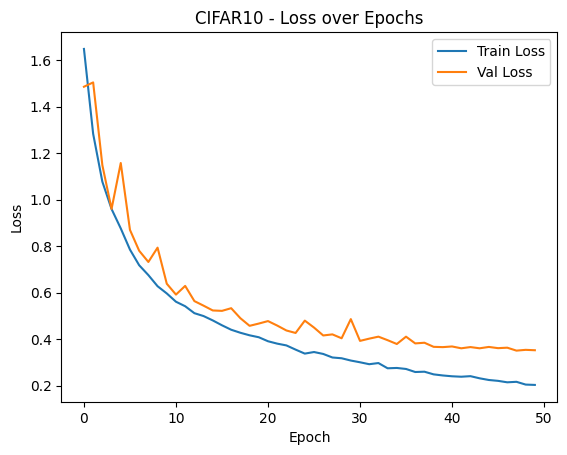


===== Training on CIFAR100 with ResNet-18 =====
Device: cuda
Number of parameters: 1,073,204
Epoch [1/50] Train Loss: 4.0316, Val Loss: 3.8502, Val Acc: 11.61% | Time: 69.17s
Epoch [2/50] Train Loss: 3.5794, Val Loss: 3.5596, Val Acc: 14.89% | Time: 9.13s
Epoch [3/50] Train Loss: 3.3171, Val Loss: 3.3709, Val Acc: 17.88% | Time: 8.94s
Epoch [4/50] Train Loss: 3.0619, Val Loss: 3.0873, Val Acc: 23.01% | Time: 9.05s
Epoch [5/50] Train Loss: 2.8281, Val Loss: 2.8140, Val Acc: 27.88% | Time: 9.04s
Epoch [6/50] Train Loss: 2.6488, Val Loss: 2.8703, Val Acc: 27.77% | Time: 8.96s
Epoch [7/50] Train Loss: 2.4986, Val Loss: 2.6542, Val Acc: 31.11% | Time: 8.99s
Epoch [8/50] Train Loss: 2.3697, Val Loss: 2.4792, Val Acc: 33.87% | Time: 9.08s
Epoch [9/50] Train Loss: 2.2464, Val Loss: 2.3641, Val Acc: 37.27% | Time: 9.03s
Epoch [10/50] Train Loss: 2.1619, Val Loss: 2.2705, Val Acc: 39.75% | Time: 9.07s
Epoch [11/50] Train Loss: 2.0701, Val Loss: 2.1707, Val Acc: 41.35% | Time: 9.13s
Epoch [12/50

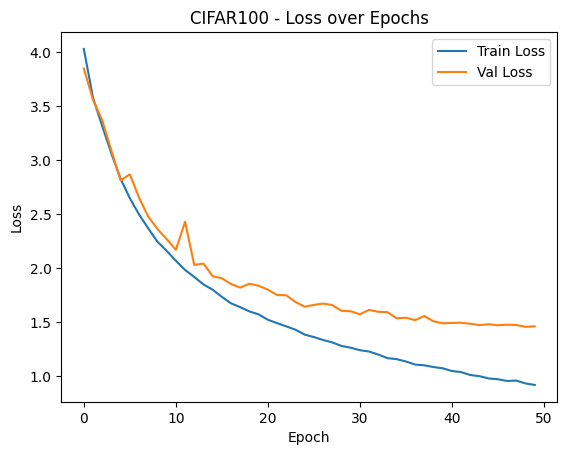

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# -------------------------------
# 1. ResNet-18 Model with Skip Connections
# -------------------------------
class BasicBlock(nn.Module):
    """Basic Residual Block used in ResNet-18."""
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.1, inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity  # Skip connection
        out = self.relu(out)

        return out


class ResNet18(nn.Module):
    """Custom ResNet-18 model for CIFAR-10 and CIFAR-100."""
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.LeakyReLU(0.1, inplace=True)

        self.layer1 = self.make_layer(32, 2, stride=1)
        self.layer2 = self.make_layer(64, 2, stride=2)
        self.layer3 = self.make_layer(128, 2, stride=2)
        self.layer4 = self.make_layer(96, 2, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(96, num_classes)

    def make_layer(self, out_channels, blocks, stride):
        """Creates layers with residual blocks."""
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = [BasicBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# -------------------------------
# 2. Training and Validation Functions
# -------------------------------
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


# -------------------------------
# 3. Training Function with Plotting
# -------------------------------
def train_and_evaluate_resnet(
    dataset_name='CIFAR10',
    num_classes=10,
    epochs=50,
    batch_size=512,
    learning_rate=1e-3
):
    """
    Train and evaluate ResNet-18 on CIFAR-10 or CIFAR-100.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n===== Training on {dataset_name} with ResNet-18 =====")
    print(f"Device: {device}")

    # 1. Load Dataset with Augmentation & Normalization
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

    if dataset_name == 'CIFAR10':
        full_dataset = torchvision.datasets.CIFAR10(
            root='./data',
            train=True,
            download=True,
            transform=transform
        )
    else:  # CIFAR100
        full_dataset = torchvision.datasets.CIFAR100(
            root='./data',
            train=True,
            download=True,
            transform=transform
        )

    # 2. 80-20 Train-Val Split
    total_size = len(full_dataset)
    val_size = int(0.2 * total_size)
    train_size = total_size - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)

    # 3. Initialize Model, Loss, Optimizer
    model = ResNet18(num_classes=num_classes).to(device)
    print(f"Number of parameters: {count_parameters(model):,}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.99)

    # 4. Training Loop
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(1, epochs+1):
        start_time = time.time()

        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        train_accs.append(tr_acc)
        val_accs.append(val_acc)

        scheduler.step()

        elapsed = time.time() - start_time
        print(f"Epoch [{epoch}/{epochs}] Train Loss: {tr_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}% | Time: {elapsed:.2f}s")

    # Plot Training & Validation Loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'{dataset_name} - Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model


if __name__ == "__main__":
    model_resnet_cifar10 = train_and_evaluate_resnet(dataset_name='CIFAR10', num_classes=10)
    model_resnet_cifar100 = train_and_evaluate_resnet(dataset_name='CIFAR100', num_classes=100)
